In [ ]:
# !pip install -q opendatasets
!pip install -q torchsummary

In [ ]:
# import opendatasets as od

# url = 'https://www.kaggle.com/hereisburak/pins-face-recognition'
# od.download(url)

In [58]:
import os

main_folder = '../input/pin-data-and-model/balanced_data/'

listdir = sorted(os.listdir(main_folder))

# for folder in listdir:
#     new_name = folder.split('_')[-1]
#     new_name = new_name.replace(" ", "_")

#     os.rename(main_folder + folder, main_folder + new_name)

In [5]:
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt

In [59]:
# stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
size = 224
batch_size=32
channels = 3

transformer = T.Compose([
    T.Resize(size), 
    T.CenterCrop(size),
    T.ToTensor(),
    T.Normalize(*stats)
])

In [60]:
dataset = ImageFolder(main_folder, transform=transformer)
classes = dataset.classes

len(dataset), dataset[0][0].size()

(47868, torch.Size([3, 224, 224]))

In [61]:
def denormal(image):
    image = image.numpy().transpose(1, 2, 0)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
#     mean = (0.5,)
#     std = (0.5,)
    
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

def denormalize(x, mean=stats[0], std=stats[1]):
    # 3, H, W, B
    ten = x.clone().permute(1, 2, 3, 0)
    for t, m, s in zip(ten, mean, std):
        t.mul_(s).add_(m)
    # B, 3, H, W
    return torch.clamp(ten, 0, 1).permute(3, 0, 1, 2)

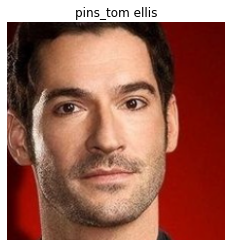

In [62]:
idx =  -1#@param
img, lbl = dataset[idx]

plt.imshow(denormal(img))
plt.title(dataset.classes[lbl])
plt.axis('off');

In [63]:
torch.manual_seed(42)

num_val = int(len(dataset) * 0.1)

dataset, val_ds = random_split(dataset, [len(dataset) - num_val, num_val])

In [64]:
from sklearn.model_selection import train_test_split

dataset = ImageFolder(main_folder, transform=transformer)
classes = dataset.classes

# Determine the size of the dataset
dataset_size = len(dataset)

# Define the train-test split ratio
test_size = 0.2  # 20% of the data will be used for testing

# Generate indices for the train-test split
indices = list(range(dataset_size))
train_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=42)

# Create the train and test subsets using the indices

val_ds = torch.utils.data.Subset(dataset, test_indices)
dataset = torch.utils.data.Subset(dataset, train_indices)
# Print the sizes of the train and test subsets
print("Train dataset size:", len(dataset))
print("Test dataset size:", len(val_ds))

# Print the size of the first image in the dataset
print("Size of the first image:", train_dataset[0][0].size())

Train dataset size: 38294
Test dataset size: 9574
Size of the first image: torch.Size([3, 224, 224])


In [67]:
dl = DataLoader(dataset, batch_size=batch_size, shuffle=False)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [69]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

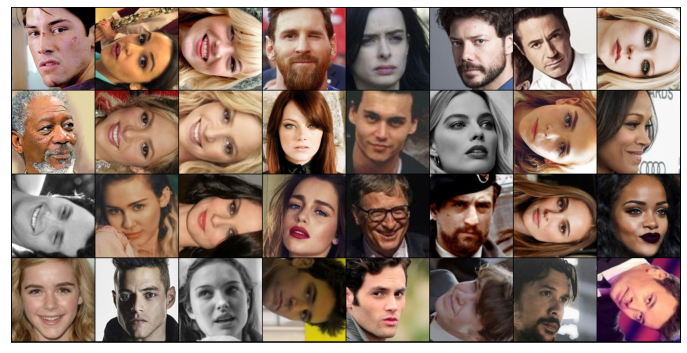

In [70]:
show_batch(dl)

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from glob import glob
from tqdm.notebook import tqdm

In [ ]:
!pip install --upgrade torchvision

In [35]:
model = models.vgg16()

In [36]:
num_ftrs = model.classifier[-1].in_features
linear = nn.Linear(num_ftrs, len(classes))
model.dropout = nn.Dropout(p=0.5)
# l2 reg
linear.weight.data.normal_(0, 0.01)
linear.bias.data.zero_()
model.classifier[-1] = linear
model=model.to(device)

In [57]:
model.load_state_dict(torch.load('../input/pin-data-and-model/balanced_data_weights.pth'))

<All keys matched successfully>

In [46]:
learning_rate = 1e-3
n_epochs = 20

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    weight_decay=1e-2
)

In [77]:
def train(epoch, n_epochs, model, dl, loss_func, device, optimizer, ds=dataset):
    model.train(True)
    torch.set_grad_enabled(True)
    
    epoch_loss = 0.0
    epochs_acc = 0
    
    tq_batch = tqdm(dl, total=len(dl))
    for images, labels in tq_batch:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outs = model(images)
        _, preds = torch.max(outs, 1)
        
        loss = loss_func(outs, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epochs_acc += torch.sum(preds == labels).item()
        
        tq_batch.set_description(f'Epoch [{epoch + 1}/{n_epochs}]')
        tq_batch.set_postfix_str('loss = {:.4f}'.format(loss.item()))

            
    epoch_loss = epoch_loss / len(dl)
    epochs_acc = epochs_acc / len(ds)

    return epoch_loss, epochs_acc

In [78]:
def evaluate(model, dl, loss_func, device, ds=val_ds):

    model.train(False)

    epoch_loss = 0
    epochs_acc = 0
    tq_batch = tqdm(dl, total=len(dl), leave=False)
    for images, labels in tq_batch:

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = loss_func(outputs, labels)

        epoch_loss += loss.item()
        epochs_acc += torch.sum(preds == labels).item()
        tq_batch.set_description(f'Evaluate Model')
        
    epoch_loss = epoch_loss / len(dl)
    epochs_acc = epochs_acc / len(ds)

    return epoch_loss, epochs_acc

In [79]:
def fit(n_epochs, model, train_dataloader, valid_dataloader, loss_func, device, optimizer):
    
    history = []
    val_loss_ref = float('inf')
    patient = 5
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        loss, acc = train(epoch, n_epochs, model, train_dataloader, loss_func, device, optimizer)
        
        torch.cuda.empty_cache()
        val_loss, val_acc = evaluate(model, valid_dataloader, loss_func, device)
        
        history.append({'loss': loss, 'acc': acc, 'val_loss': val_loss, 'val_acc': val_acc})

        statement = "[loss]={:.4f} - [acc]={:.4f} - \
[val_loss]={:.4f} - [val_acc]={:.4f}".format(loss, acc, val_loss, val_acc,)
        print(statement)
#         ####### Checkpoint
#         if val_loss < val_loss_ref:
#             patient = 5
#             val_loss_ref = val_loss
#             model_path = './Face_Recognition_checkpoint.pth'
#             torch.save(model.state_dict(), model_path)
#             print(f"[INFO] Saving model dict, Epoch={epoch + 1}")
#         else:
#             if patient == 0: 
#                 break
#             print(f"[INFO] {patient} lives left!")
#             patient -= 1
            

    return history

In [ ]:
res = fit(15, model, dl, val_dl, criterion, device, optimizer)

  0%|          | 0/1197 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

[loss]=0.5640 - [acc]=0.8441 - [val_loss]=0.2049 - [val_acc]=0.9509


  0%|          | 0/1197 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

[loss]=0.2414 - [acc]=0.9335 - [val_loss]=0.1929 - [val_acc]=0.9501


  0%|          | 0/1197 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

[loss]=0.1667 - [acc]=0.9548 - [val_loss]=0.1373 - [val_acc]=0.9619


  0%|          | 0/1197 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

[loss]=0.1375 - [acc]=0.9621 - [val_loss]=0.1274 - [val_acc]=0.9642


  0%|          | 0/1197 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

[loss]=0.1173 - [acc]=0.9677 - [val_loss]=0.1527 - [val_acc]=0.9587


  0%|          | 0/1197 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

[loss]=0.1014 - [acc]=0.9717 - [val_loss]=0.1210 - [val_acc]=0.9659


  0%|          | 0/1197 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
def show_results(history):
    accuracy = [res['acc'] for res in history]
    losses = [res['loss'] for res in history]
    val_accuracy = [res['val_acc'] for res in history]
    val_losses = [res['val_loss'] for res in history]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    ax1.plot(losses, '-o', label = 'Loss')
    ax1.plot(val_losses, '-o', label = 'Validation Loss')
    ax1.legend()

    ax2.plot(100 * np.array(accuracy), '-o', label = 'Accuracy')
    ax2.plot(100 * np.array(val_accuracy), '-o', label = 'Validation Accuracy')
    ax2.legend();
    
    fig.show()

In [ ]:
show_results(res)

In [ ]:
y_test, y_pred = [], []
for imgs, lbls in tqdm(val_dl):
    imgs = imgs.to(device)
    outs = model(imgs)
    _, preds = torch.max(outs, dim = 1)
    y_test += lbls.tolist()
    y_pred += preds.tolist()

In [ ]:
loss, acc = evaluate(model, val_dl, criterion, device)
print(f'loss: {loss} - acc: {acc}')

In [ ]:
from termcolor import colored


for i, name in enumerate(classes):
    name = name.split("_")[-1]
    classes[i] = name

# classes

In [ ]:
idx = 16
for imgs, lbls in val_dl:
    imgs = imgs.to(device)
    outs = model(imgs)
    _, preds = torch.max(outs, dim = 1)
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_images = denormalize(imgs.cpu())
    ax.imshow(make_grid(denorm_images[:idx], nrow=8).permute(1, 2, 0).clamp(0,1))
    for p, lbl in zip(preds[:idx], lbls[:idx]):
        if lbl == p.cpu():
            print(colored(classes[p], 'green'))
        else:
            print(colored(classes[p], 'red'), colored(classes[lbl], 'blue'))
    break

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns

In [ ]:
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(50, 50))
plt.title('Confusion Matrix')
sns.heatmap(cm_df, annot=True, cmap='Blues', square=True);

In [ ]:
print(classification_report(y_test, y_pred)) 